In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

#Create df from hatchery file
esc = pd.read_csv('skykomishHatcheries.csv', low_memory=False)
esc['Date'] = pd.to_datetime(esc['Date'])
esc = esc[['Date', 'Facility', 'Adult Count', 'Species', 'Event']]
esc = esc[esc.Facility == 'WALLACE R HATCHERY']
esc = esc[esc.Event == 'Trap Estimate']
esc = esc[esc.Species == 'Coho']
esc = esc.sort_values('Date')



#Creat df from rivers file
df = pd.read_csv('sky.txt', sep='\t', header=None)
df = df.rename(columns ={2:"Date",3:"cfs"})
df = df.drop(columns=[0,1,4],)
df['Date'] = df['Date'].astype('datetime64[ns]')
df.head()

#Specify date range for each species
df_time = esc
first = df_time.iloc[0].Date
last = df_time.iloc[-1].Date
print(first, last)

#Merge data frames and trim for species date range
plt_tst = pd.merge(df, esc, on=['Date'], how='outer')
rt = (plt_tst['Date'] >= first) & (plt_tst['Date'] <= last)
plt_tst = plt_tst.loc[rt]
plt_tst['Year'] = plt_tst['Date'].dt.strftime('%Y').astype(np.int64)
plt_tst = plt_tst[plt_tst.Year >= 2015]
plt_tst.info()
plt_tst['Adult Count'] = plt_tst['Adult Count'].fillna(0).astype(np.int64)
plt_tst['returnBinary'] = plt_tst['Adult Count'].astype(np.int64)
plt_tst.loc[plt_tst.returnBinary > 0, 'returnBinary'] = 1
plt_tst.info()
plt_tst.tail()


1997-09-23 00:00:00 2020-11-12 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2192 entries, 6398 to 8589
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2192 non-null   datetime64[ns]
 1   cfs          2192 non-null   int64         
 2   Facility     232 non-null    object        
 3   Adult Count  232 non-null    float64       
 4   Species      232 non-null    object        
 5   Event        232 non-null    object        
 6   Year         2192 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 137.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2192 entries, 6398 to 8589
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2192 non-null   datetime64[ns]
 1   cfs           2192 non-null   int64         
 2   Facility     

,Date,cfs,Facility,Adult Count,Species,Event,Year,returnBinary
8585,2020-11-09,4510,WALLACE R HATCHERY,340,Coho,Trap Estimate,2020,1
8586,2020-11-10,4040,WALLACE R HATCHERY,34,Coho,Trap Estimate,2020,1
8587,2020-11-10,4040,WALLACE R HATCHERY,100,Coho,Trap Estimate,2020,1
8588,2020-11-11,3560,WALLACE R HATCHERY,100,Coho,Trap Estimate,2020,1
8589,2020-11-12,3170,WALLACE R HATCHERY,9,Coho,Trap Estimate,2020,1


In [2]:
tf = plt_tst.groupby('Year').sum('Adult Count')
sf = plt_tst.set_index('Year')
sf = sf.merge(tf, on='Year')
sf = sf[['Adult Count_x', 'cfs_x','Date','returnBinary_y', 'Adult Count_y','returnBinary_x']]
sf = sf.rename(columns = {'Adult Count_x':'Count', 'cfs_x':'cfs','returnBinary_y':'#obsv','returnBinary_x':'returnBinary','Adult Count_y':'yearTotal'})
sf['%total'] = sf.Count/sf.yearTotal
sf = sf.set_index('Date')


In [3]:
sf = sf[['%total','cfs']]
sf.head()

,%total,cfs
Date,,
2015-01-01,0.0,2920
2015-01-02,0.0,2720
2015-01-03,0.0,2520
2015-01-04,0.0,2680
2015-01-05,0.0,21400


In [4]:
pearson_r = sf.corr()
print(f"Pandas computed Pearson r: {pearson_r}")

r, p = stats.pearsonr(sf['%total'], sf['cfs'])
print(f"Scipy Pearson r: {r} and p-value: {p}")

Pandas computed Pearson r:           %total       cfs
%total  1.000000  0.235641
cfs     0.235641  1.000000
Scipy Pearson r: 0.2356406488845358 and p-value: 4.885502067042022e-29


In [5]:

x = sf.rolling(4).corr(pairwise=True)
x

%total       cfs
Date                                 
2015-01-01 %total       NaN       NaN
           cfs          NaN       NaN
2015-01-02 %total       NaN       NaN
           cfs          NaN       NaN
2015-01-03 %total       NaN       NaN
...                     ...       ...
2020-11-10 cfs     0.656060  1.000000
2020-11-11 %total  1.000000  0.722791
           cfs     0.722791  1.000000
2020-11-12 %total  1.000000  0.446248
           cfs     0.446248  1.000000

[4384 rows x 2 columns]

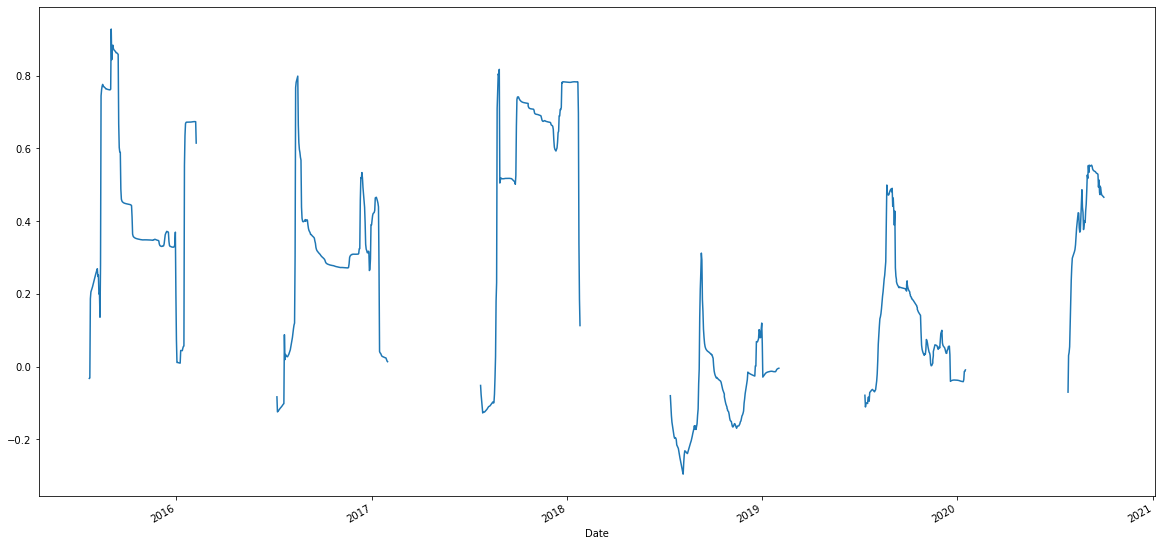

In [6]:
f,ax = plt.subplots(figsize=(20, 10))
rolling_r = sf['cfs'].rolling(window=120, center=True).corr(sf['%total']).plot(ax=ax)

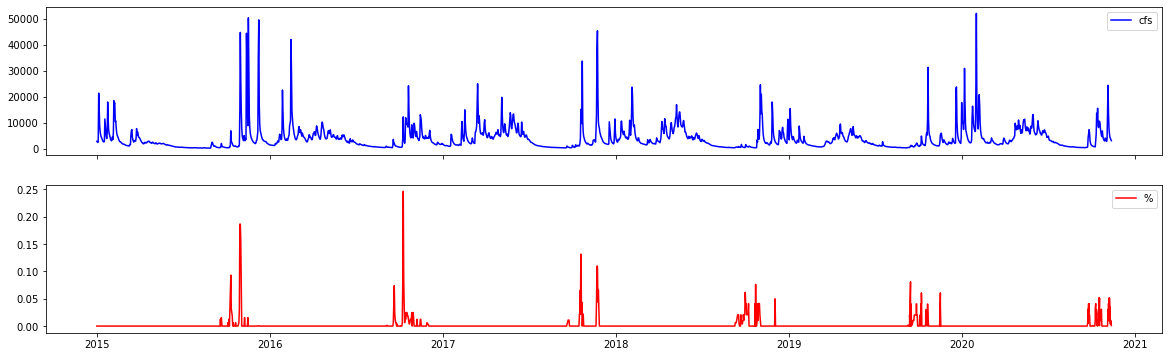

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
ax[0].plot(sf['cfs'], color='b', label='cfs')
ax[0].legend()
ax[1].plot(sf['%total'], color='r', label='%')
ax[1].legend()
plt.show()

In [8]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [9]:
d1, d2 = sf['cfs'], sf['%total']
window = 10
# lags = np.arange(-(fs), (fs), 1)  # uncontrained
lags = np.arange(-(200), (200), 1)  # contrained
rs = np.nan_to_num([crosscorr(d1, d2, lag) for lag in lags])

print("xcorr {}-{}".format(sf['cfs'], sf['%total']), lags[np.argmax(rs)], np.max(rs))

xcorr Date
2015-01-01     2920
2015-01-02     2720
2015-01-03     2520
2015-01-04     2680
2015-01-05    21400
              ...  
2020-11-09     4510
2020-11-10     4040
2020-11-10     4040
2020-11-11     3560
2020-11-12     3170
Name: cfs, Length: 2192, dtype: int64-Date
2015-01-01    0.000000
2015-01-02    0.000000
2015-01-03    0.000000
2015-01-04    0.000000
2015-01-05    0.000000
                ...   
2020-11-09    0.034825
2020-11-10    0.003483
2020-11-10    0.010243
2020-11-11    0.010243
2020-11-12    0.000922
Name: %total, Length: 2192, dtype: float64 38 0.2871649371440633


Text(0.5, 1.0, 'Cross-correlation')

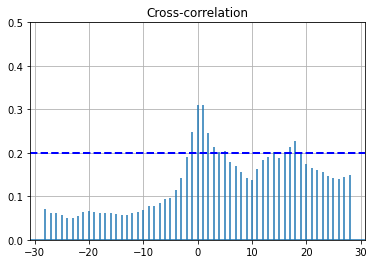

In [11]:
plt.xcorr(sf['cfs'], sf['%total'], usevlines=True, maxlags=28)
plt.grid(True)
plt.axhline(0.2, color='blue', linestyle='dashed', lw=2)
plt.ylim([0, 0.5])
plt.title("Cross-correlation")